In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import math
from os import listdir
import librosa
import IPython.display as ipd

In [ ]:
def resample(aud):
    y, sr = librosa.load(aud)
    y_4k = librosa.resample(y, sr, 4000)
    return y_4k

In [ ]:
import matplotlib.pyplot as plt
def get_spectrogram(wav):
    D = librosa.stft(wav, n_fft=100, hop_length=40,
                     win_length=100, window='hamming')
    spect, phase = librosa.magphase(D)
    return spect
def spectrogram(wav):
    log_spect = np.log(get_spectrogram(wav))
    print('spectrogram shape:', log_spect.shape)
    plt.imshow(log_spect, aspect='auto', origin='lower',)
    plt.title('spectrogram of origin audio')
    plt.show()

In [ ]:
def assign_label(aud):
    label = aud.split("_")
    label = label[0]
    return label

In [ ]:
# wav, sr= librosa.load(os.path.join(new_cough9_path, 'Barking cough_1.wav'))
# print(sr)

In [ ]:
# s = get_spectrogram(wav)
# print(s.shape)

In [ ]:
def log_mel_aud(aud):
    wav, sr = librosa.load(aud)
    frame_size = 2048
    hop_size = 512
    aud_stft = librosa.stft(wav, n_fft = frame_size, hop_length = hop_size)
    y = np.abs(aud_stft)**2
    y_mel = librosa.feature.melspectrogram(S=y, sr = sr, n_mels = 64)
    y_db = librosa.power_to_db(y_mel)
    return y_db

In [ ]:
cough_path = "/content/drive/MyDrive/dataset/cough9"
labels =[]
mel_spec = []
count = 0
for file in listdir(cough_path):
    count += 1
    link = os.path.join(cough_path, file)
    log_mel = log_mel_aud(link)
    mel_spec.append(log_mel)
    label = assign_label(file)
    labels.append(label)

In [ ]:
spec= np.array(mel_spec)
labels= np.array(labels)

In [ ]:
l = []
c = []
c1 = 1
l1 = sorted(labels)
for i in l1:
    if (i not in l):
        c.append(c1)
        l.append(i)
        c1 =  1
    else: 
        c1 += 1
c.append(c1)
        
print(l)
print(c[1:])

['Barking cough', 'Chesty and wet cough', 'Coughing hard', 'Coughing up crap again', 'Dry Afternoon Cough', 'Gaggy wet cough', 'Night wet cough', 'Spring Allergy Coughing', 'Unknow']
[1040, 1664, 60, 884, 1040, 1118, 1300, 884, 1557]


In [ ]:
print(spec.shape)
print(labels.shape)

(9547, 64, 44)
(9547,)


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
label_encoder = encoder.fit_transform(labels)
print(label_encoder)
new_label = label_encoder.reshape(-1,1)
encoder2 = OneHotEncoder(sparse=False)
label_e = encoder2.fit_transform(new_label)
print(encoder2.fit_transform(new_label))

[8 8 8 ... 1 1 1]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [ ]:
# Define network

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential, regularizers


def regularized_padded_conv(*args, **kwargs):
    return layers.Conv2D(*args, **kwargs, padding='same', use_bias=False, kernel_initializer='he_normal',
                         kernel_regularizer=regularizers.l2(5e-4))

class ChannelAttention(layers.Layer):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg = layers.GlobalAveragePooling2D()
        self.max = layers.GlobalMaxPooling2D()
        self.conv1 = layers.Conv2D(in_planes // ratio, kernel_size=1, strides=1, padding='same',
                                   kernel_regularizer=regularizers.l2(5e-4),
                                   use_bias=True, activation=tf.nn.relu)
        self.conv2 = layers.Conv2D(in_planes, kernel_size=1, strides=1, padding='same',
                                   kernel_regularizer=regularizers.l2(5e-4),
                                   use_bias=True)

    def call(self, inputs):
        avg = self.avg(inputs)
        max = self.max(inputs)
        avg = layers.Reshape((1, 1, avg.shape[1]))(avg)  # shape (None, 1, 1 feature)
        max = layers.Reshape((1, 1, max.shape[1]))(max)  # shape (None, 1, 1 feature)
        avg_out = self.conv2(self.conv1(avg))
        max_out = self.conv2(self.conv1(max))
        out = avg_out + max_out
        out = tf.nn.sigmoid(out)

        return out

class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = regularized_padded_conv(1, kernel_size=kernel_size, strides=1, activation=tf.nn.sigmoid)

    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=3)
        max_out = tf.reduce_max(inputs, axis=3)
        out = tf.stack([avg_out, max_out], axis=3)
        out = self.conv1(out)

        return out

class BasicBlock(layers.Layer):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = regularized_padded_conv(out_channels, kernel_size=3, strides=stride)
        self.bn1 = layers.BatchNormalization()

        self.conv2 = regularized_padded_conv(out_channels, kernel_size=3, strides=1)
        self.bn2 = layers.BatchNormalization()
        self.ca = ChannelAttention(out_channels)
        self.sa = SpatialAttention()

        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = Sequential([regularized_padded_conv(self.expansion * out_channels,
                                                                kernel_size=1, strides=stride),
                                        layers.BatchNormalization()])
        else:
            self.shortcut = lambda x, _: x

    def call(self, inputs, training=False):
        out = self.conv1(inputs)
        out = self.bn1(out, training=training)
        out = tf.nn.relu(out)

        out = self.conv2(out)
        out = self.bn2(out, training=training)
        out = self.ca(out) * out
        out = self.sa(out) * out

        out = out + self.shortcut(inputs, training)
        out = tf.nn.relu(out)

        return out


class Bottleneck(keras.Model):
    expansion = 4

    def __init__(self, in_channels, out_channels, strides=1):
        super(Bottleneck, self).__init__()

        self.conv1 = regularized_padded_conv(out_channels, 1, 1)
        self.bn1 = layers.BatchNormalization()

        self.conv2 = regularized_padded_conv(out_channels, 3, strides)
        self.bn2 = layers.BatchNormalization()
        self.conv3 = regularized_padded_conv(out_channels * self.expansion, 1, 1)
        self.bn3 = layers.BatchNormalization()

        if strides != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = Sequential([regularized_padded_conv(self.expansion * out_channels, kernel_size=1,
                                                                strides=strides),
                                        layers.BatchNormalization()])
        else:
            self.shortcut = lambda x, _: x

    def call(self, x, training=False):
        out = tf.nn.relu(self.bn1(self.conv1(x), training))
        out = tf.nn.relu(self.bn2(self.conv2(out), training))
        out = self.bn3(self.conv3(out), training)

        out = out + self.shortcut(x, training)
        out = tf.nn.relu(out)

        return out


class ResNet(keras.Model):

    def __init__(self, blocks, layer_dims, num_classes=9):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.stem = Sequential([regularized_padded_conv(64, kernel_size=3, strides=1),
                                layers.BatchNormalization()])

        self.layer1 = self.build_resblock(blocks, 64, layer_dims[0], stride=1)
        self.layer2 = self.build_resblock(blocks, 128, layer_dims[1], stride=2)
        self.layer3 = self.build_resblock(blocks, 256, layer_dims[2], stride=2)
        self.layer4 = self.build_resblock(blocks, 512, layer_dims[3], stride=2)
        self.final_bn  = layers.BatchNormalization()

        self.avgpool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes, activation='softmax')

    # 2. ResBlock
    def build_resblock(self, blocks, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)  # [1]*3 = [1, 1, 1]
        res_blocks = Sequential()

        for stride in strides:
            res_blocks.add(blocks(self.in_channels, out_channels, stride))
            self.in_channels = out_channels

        return res_blocks

    def call(self, inputs, training=False):
        out = self.stem(inputs, training)
        out = tf.nn.relu(out)

        out = self.layer1(out, training=training)
        out = self.layer2(out, training=training)
        out = self.layer3(out, training=training)
        out = self.layer4(out, training=training)
        out = self.final_bn(out, training=training)
        out = tf.nn.relu(out)

        out = self.avgpool(out)
        out = self.fc(out)

        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
sample_height = 64
sample_width = 44

In [ ]:
model = ResNet18()
model.build(input_shape=(None, sample_height, sample_width, 1))
model.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 44, 64)        832       
                                                                 
 sequential_1 (Sequential)   (None, 64, 44, 64)        149836    
                                                                 
 sequential_2 (Sequential)   (None, 32, 22, 128)       531412    
                                                                 
 sequential_4 (Sequential)   (None, 16, 11, 256)       2119396   
                                                                 
 sequential_6 (Sequential)   (None, 8, 6, 512)         8465668   
                                                                 
 batch_normalization_20 (Bat  multiple                 2048      
 chNormalization)                                                
                                                           

In [ ]:
X = tf.random.uniform(shape=(1, 224, 224, 1))
for layer in model.layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 (1, 224, 224, 64)
Sequential output shape:	 (1, 224, 224, 64)
Sequential output shape:	 (1, 112, 112, 128)
Sequential output shape:	 (1, 56, 56, 256)
Sequential output shape:	 (1, 28, 28, 512)
BatchNormalization output shape:	 (1, 28, 28, 512)
GlobalAveragePooling2D output shape:	 (1, 512)
Dense output shape:	 (1, 9)


In [ ]:
from tensorflow.keras import optimizers
opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer =  opt, loss = 'categorical_crossentropy', metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from sklearn.model_selection import train_test_split
x_train1, x_test, y_train1, y_test = train_test_split(spec, label_e, test_size=0.1, shuffle = True)
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, test_size=0.2, shuffle = True)

In [ ]:
print(x_train1[2].shape)

(64, 44)


In [ ]:
x = x_train1[2].reshape(-1, sample_height, sample_width, 1)

In [ ]:
print(x.shape)

(1, 64, 44, 1)


In [ ]:
x_train_f = x_train.reshape(-1, sample_height, sample_width, 1)
print(x_train_f.shape)
x_test_f = x_test.reshape(-1, sample_height, sample_width, 1)
print(x_test_f.shape)
x_val_f = x_val.reshape(-1, sample_height, sample_width, 1)
print(x_val_f.shape)

(6873, 64, 44, 1)
(955, 64, 44, 1)
(1719, 64, 44, 1)


In [ ]:
batch_size = 64
n_epochs = 10

In [ ]:
history = model.fit(x_train_f, y_train, validation_data= (x_val_f, y_val), epochs=10, batch_size=20, verbose = 1)

Epoch 1/10
344/344 [==============================] - 90s 229ms/step - loss: 5.7920 - accuracy: 0.6735 - val_loss: 5.1471 - val_accuracy: 0.7906
Epoch 2/10
344/344 [==============================] - 76s 221ms/step - loss: 4.6892 - accuracy: 0.9070 - val_loss: 4.5588 - val_accuracy: 0.8732
Epoch 3/10
344/344 [==============================] - 76s 221ms/step - loss: 4.1699 - accuracy: 0.9491 - val_loss: 4.0609 - val_accuracy: 0.9372
Epoch 4/10
344/344 [==============================] - 76s 221ms/step - loss: 3.7625 - accuracy: 0.9722 - val_loss: 3.9323 - val_accuracy: 0.8656
Epoch 5/10
344/344 [==============================] - 76s 221ms/step - loss: 3.4208 - accuracy: 0.9817 - val_loss: 3.5716 - val_accuracy: 0.8965
Epoch 6/10
344/344 [==============================] - 76s 221ms/step - loss: 3.1270 - accuracy: 0.9879 - val_loss: 3.8447 - val_accuracy: 0.7836
Epoch 7/10
344/344 [==============================] - 76s 221ms/step - loss: 2.8846 - accuracy: 0.9873 - val_loss: 3.0859 - val_ac

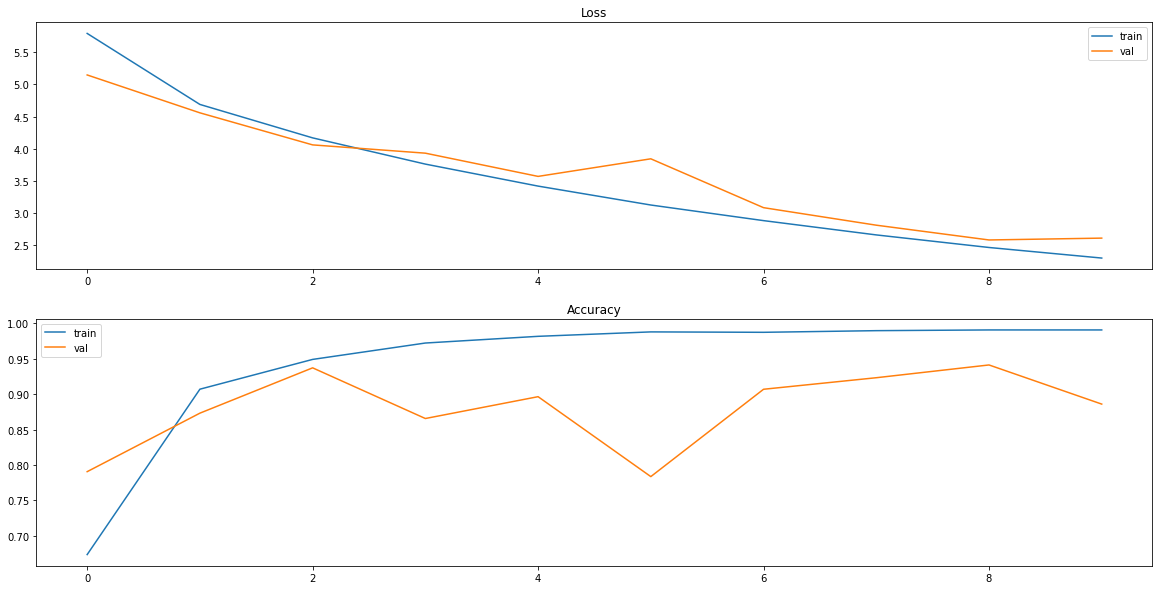

In [ ]:
import matplotlib.pyplot as pyplot

# plot loss và accuracy
pyplot.figure(figsize=(20,10))
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

In [ ]:
prediction = model.predict(x_test_f)
pre = np.argmax(model.predict(x_test_f), axis=-1)
print(prediction[0])

[1.6211939e-07 4.5922857e-07 5.5253011e-08 3.5758992e-05 6.0789995e-07
 1.0612149e-08 9.9996257e-01 3.1793576e-07 7.5898772e-09]


In [ ]:
print(pre[0])

6


In [ ]:
y_test[5]

array([0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [ ]:
# evaluate the model
score = model.evaluate(x_test_f, y_test, verbose=0)
print(score)
print("loss: ", score[0]) #loss
print("acc: ", score[1]) #acc

[2.626462697982788, 0.8743455410003662]
loss:  2.626462697982788
acc:  0.8743455410003662


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = []
for i in y_test:
    y_true.append(np.argmax(i))
y_true = np.array(y_true)
classes=['0','1', '2', '3', '4', '5', '6', '7', '8']
print(classification_report(y_true, pre, target_names=classes))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       108
           1       0.95      0.78      0.86       163
           2       0.83      0.83      0.83         6
           3       0.78      0.94      0.85        93
           4       0.97      0.86      0.91        96
           5       1.00      0.62      0.76       128
           6       0.69      0.95      0.80       136
           7       0.81      0.96      0.88        84
           8       0.98      1.00      0.99       141

    accuracy                           0.87       955
   macro avg       0.89      0.88      0.87       955
weighted avg       0.90      0.87      0.87       955



In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix: 
 [[103   0   1   0   0   0   3   1   0]
 [  2 127   0   7   1   0  18   8   0]
 [  0   0   5   0   0   0   0   0   1]
 [  0   1   0  87   1   0   4   0   0]
 [  0   2   0   2  83   0   6   2   1]
 [  0   1   0  15   0  79  26   7   0]
 [  1   3   0   1   1   0 129   1   0]
 [  0   0   0   0   0   0   2  81   1]
 [  0   0   0   0   0   0   0   0 141]]


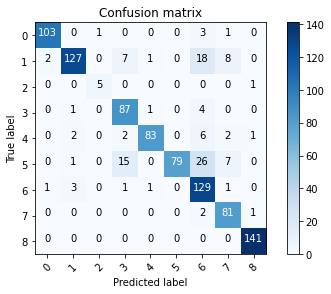

In [ ]:
y_pred = pre
cm_train = confusion_matrix(y_true, y_pred) 
print('Confusion matrix: \n', cm_train)
plot_confusion_matrix(cm_train, classes=['0','1', '2', '3', '4', '5', '6', '7', '8'],
                      title='Confusion matrix')

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
filepath = './saved_model_abnormal_cough'
save_model(model, filepath)
model.save_weights('cough_weights.h5')

INFO:tensorflow:Assets written to: ./saved_model_abnormal_cough/assets


INFO:tensorflow:Assets written to: ./saved_model_abnormal_cough/assets


In [ ]:
!zip -r /content/saved_model_abnormal_cough.zip /content/saved_model_abnormal_cough

  adding: content/saved_model_abnormal_cough/ (stored 0%)
  adding: content/saved_model_abnormal_cough/saved_model.pb (deflated 91%)
  adding: content/saved_model_abnormal_cough/variables/ (stored 0%)
  adding: content/saved_model_abnormal_cough/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_model_abnormal_cough/variables/variables.index (deflated 77%)
  adding: content/saved_model_abnormal_cough/assets/ (stored 0%)
  adding: content/saved_model_abnormal_cough/keras_metadata.pb (deflated 95%)
